<a href="https://colab.research.google.com/github/componavt/differential_equations/blob/main/src/hill_equation/9_ODU%20system_and_Phase_plane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧬📉 Phase-Space Analysis of Gene Regulatory System

- **Goal**: Analyze phase dynamics, bifurcations, and sensitivity in a gene-regulatory ODE system  
  System of equations:
  $$
  \frac{dx}{dt} = \frac{K \cdot x^{1/\alpha}}{b^{1/\alpha} + x^{1/\alpha}}, \quad
  \frac{dy}{dt} = \frac{K \cdot y^{1/\alpha}}{b^{1/\alpha} + x^{1/\alpha}}
  $$
- **Initial conditions**: $x(0) \approx b = 1.0$, $y(0) \approx b = 1.0$  
- **Time interval**: $t \in [0, t_{\text{end}}]$  
- **Alpha range**: $\alpha \in [10^{-5}, 10^{-4}]$ (logarithmically spaced)  
- **Multiplier values**: $K \in \{0.5, 1.0, 1.5, 2.0, 2.5\}$  

## ⚙️ Solvers Used
- ⚡ `RK45` – Explicit Runge-Kutta, adaptive step  
- 🌐 `DOP853` – High-order Dormand-Prince  
- 🧱 `BDF` – Implicit multistep for stiff systems  
- 🧿 `Radau` – A-stable implicit Runge-Kutta  
- 🐢 `RK23` – Lower-order fallback method  
- 🌀 `Symplectic` – Custom explicit Euler as phase-preserving baseline

## 📈 Features and Diagnostics
- ✅ Phase plots $y(t)$ vs $x(t)$ for each solver  
- ➡️ Arrows indicate flow direction (small quivers on trajectory)  
- 🛡️ Clipping and log-exp transformation to handle overflow  
- 💾 All numerical errors logged per solver  
- 🧠 Comparison table with:
  - Total integration time
  - `nfev`: number of function evaluations (integration effort)

## 🧪 Advanced Analyses
- 📉 **Lyapunov Exponent**:  
  Approximated via divergence of nearby trajectories.  
  Positive exponent ⇒ sensitive dependence ⇒ possible chaos.

- 🌪️ **Neimark–Sacker Bifurcation Detection**:  
  - Poincaré map estimation  
  - Jacobian from finite differences  
  - Eigenvalue spectrum used to assess bifurcation (crossing unit circle)

## 📌 Notes
- Symplectic solver is not native; used simple explicit Euler as an illustrative placeholder.
- Poincaré map defined as final point of time evolution over fixed interval $[0, t_{\text{end}}]$.
- Overflow control uses $\log$-domain clipping to avoid `NaN` / `Inf` issues.

In [13]:
# Modified code for a gene regulatory system with phase space visualization

# Cell 1: Parameters and library imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pickle
import time
from matplotlib import cm
from numpy.linalg import eigvals

b = 1.0
x0 = b * (1 - 1e-11)
y0 = b * (1 - 1e-11)  # same initial condition for y
t_end = 0.05
K_list = np.arange(0.5, 3.0, 0.5)
alpha_list = np.logspace(-4, -5, 10)
N = 500
t_eval = np.linspace(0, t_end, N)

print("Alpha values:", alpha_list)

MAX_LOG_MESSAGES = 3
all_methods = ["RK45", "DOP853", "BDF", "Radau", "RK23", "Symplectic"]
error_counts = {m: 0 for m in all_methods}
error_counts.update({m + '_msgs': 0 for m in all_methods})
fail_counts = {m: 0 for m in all_methods}

# Style map for plotting
style_map = {}
for idx, alpha in enumerate(alpha_list):
    style_map[alpha] = {
        "color": plt.cm.tab10(idx % 10),
        "marker": ['o', 's', '^', 'v', 'D', '*', 'x', 'P', 'H', '>'][idx % 10],
        "linestyle": ['-', '--', ':', '-.', (0, (3, 1, 1, 1))][idx % 5]
    }

Alpha values: [1.00000000e-04 7.74263683e-05 5.99484250e-05 4.64158883e-05
 3.59381366e-05 2.78255940e-05 2.15443469e-05 1.66810054e-05
 1.29154967e-05 1.00000000e-05]


In [14]:
# Cell 2: RHS for system of two ODEs

def get_rhs_system(alpha, method_name, error_log, K):
    error_log.setdefault(method_name + '_msgs', 0)

    def rhs(t, xy):
        x_safe = np.clip(xy[0], 1e-20, 1e20)
        y_safe = np.clip(xy[1], 1e-20, 1e20)
        inv_alpha = 1 / alpha
        try:
            log_x = np.log(x_safe)
            log_y = np.log(y_safe)
            log_b = np.log(b)
            exp_power_x = np.clip(log_x * inv_alpha, -700, 700)
            exp_power_y = np.clip(log_y * inv_alpha, -700, 700)
            exp_power_b = np.clip(log_b * inv_alpha, -700, 700)
            exp_x = np.exp(exp_power_x)
            exp_y = np.exp(exp_power_y)
            exp_b = np.exp(exp_power_b)
            denom = exp_b + exp_x
            dxdt = K * exp_x / denom
            dydt = K * exp_y / denom  # note: x still in denom!
            return [dxdt, dydt]
        except Exception as e:
            error_log[method_name] += 1
            if error_log[method_name + '_msgs'] < MAX_LOG_MESSAGES:
                msg = f"Numerical error in {method_name} at t={t:.5f}, x={x_safe:.5f}, y={y_safe:.5f}, alpha={alpha:.2e}: {e}"
                print(msg)
                error_log[method_name + '_msgs'] += 1
            return [0.0, 0.0]

    return rhs

In [15]:
# Cell 3: Solve the system for all methods
all_results_2d = {m: [] for m in all_methods}
timings = {}
nfevs = {}
reference_method = "DOP853"

for method in all_methods:
    total_time = 0
    total_nfev = 0
    print(f"Solving with method: {method}")
    for index, alpha in enumerate(alpha_list):
        for K in K_list:
            rhs = get_rhs_system(alpha, method, error_counts, K)
            start = time.time()
            try:
                if method == "Symplectic":
                    dt = t_eval[1] - t_eval[0]
                    x = [x0]
                    y = [y0]
                    for t_i in t_eval[:-1]:
                        rhs_val = rhs(t_i, [x[-1], y[-1]])
                        x.append(x[-1] + dt * rhs_val[0])
                        y.append(y[-1] + dt * rhs_val[1])
                    sol_x = np.array(x)
                    sol_y = np.array(y)
                    sol_nfev = len(x)
                else:
                    sol = solve_ivp(rhs, [0, t_end], [x0, y0], t_eval=t_eval, method=method)
                    sol_x = sol.y[0]
                    sol_y = sol.y[1]
                    sol_nfev = sol.nfev
                duration = time.time() - start
                total_time += duration
                total_nfev += sol_nfev
                all_results_2d[method].append((sol_x, sol_y, alpha, K))
            except Exception as e:
                print(f"{method} failed for alpha={alpha:.2e}, K={K:.1f}: {e}")
                fail_counts[method] += 1
    timings[method] = total_time
    nfevs[method] = total_nfev

Solving with method: RK45
Solving with method: DOP853
Solving with method: BDF
Solving with method: Radau
Solving with method: RK23
Solving with method: Symplectic


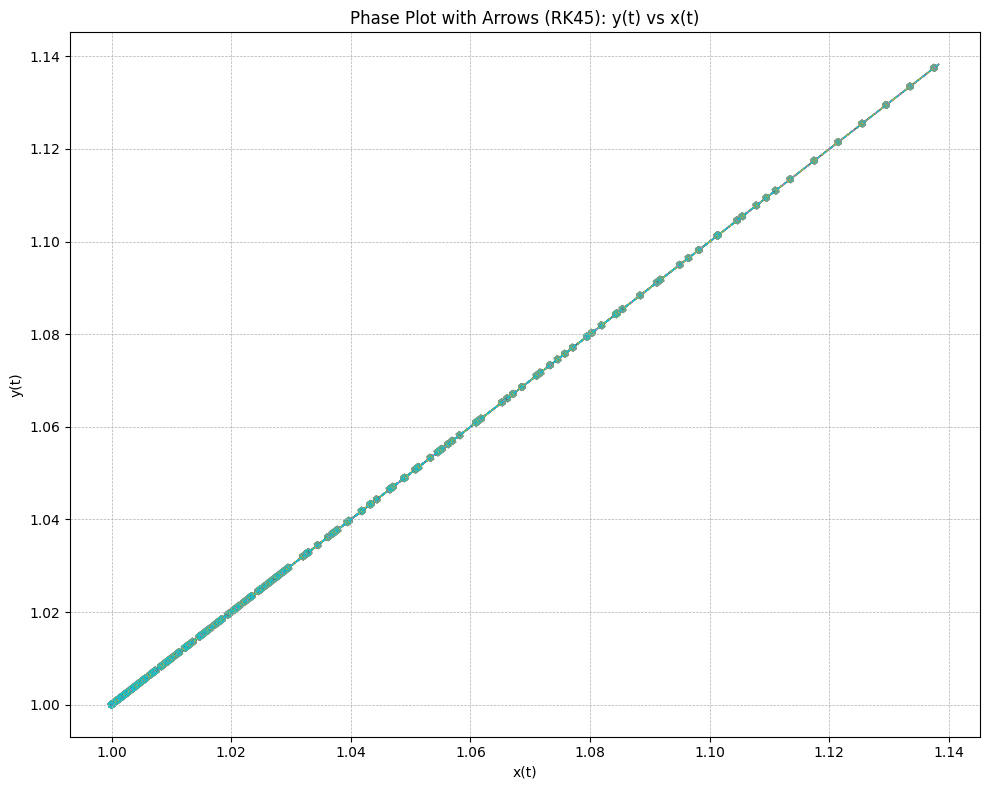

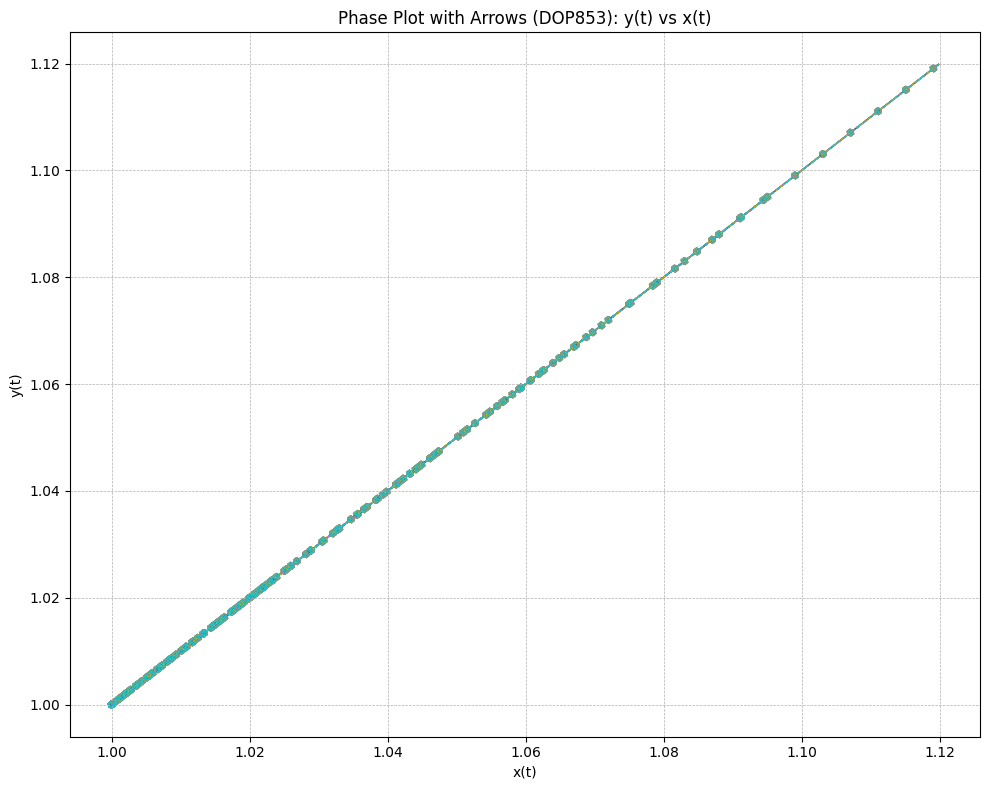

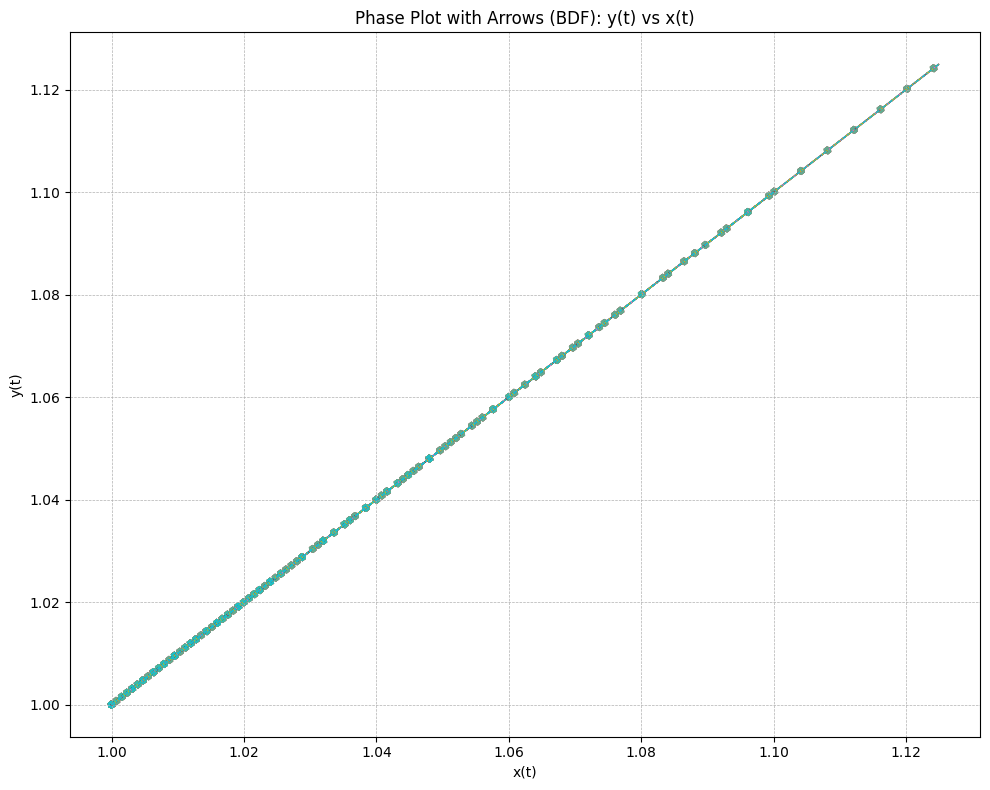

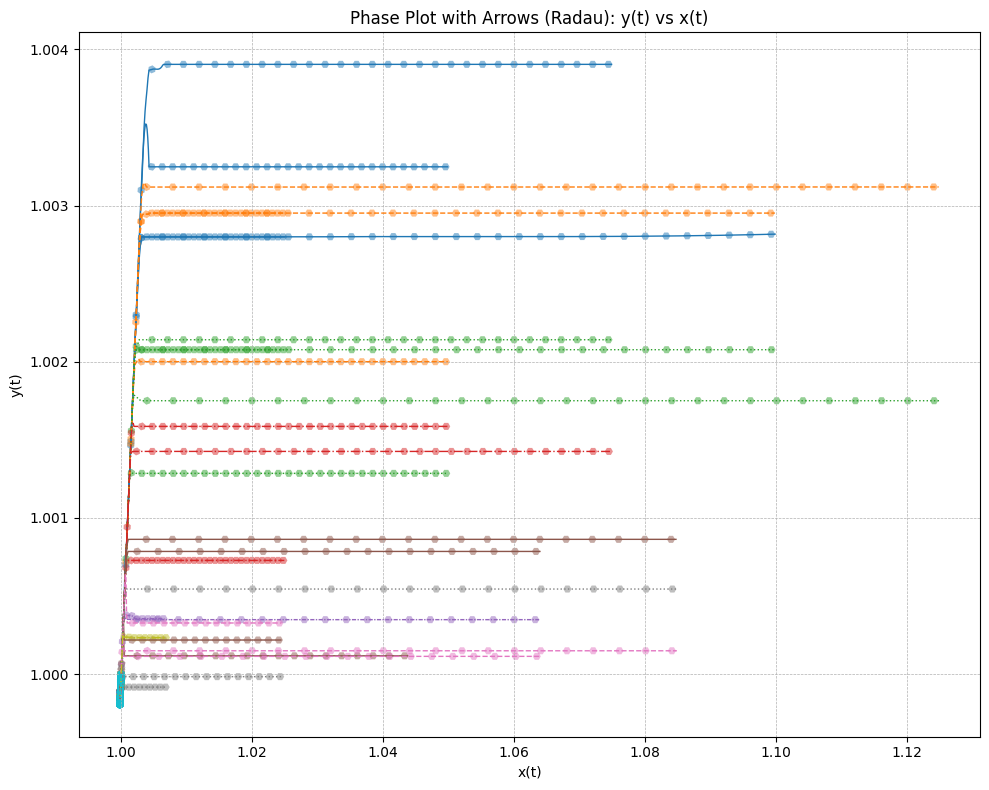

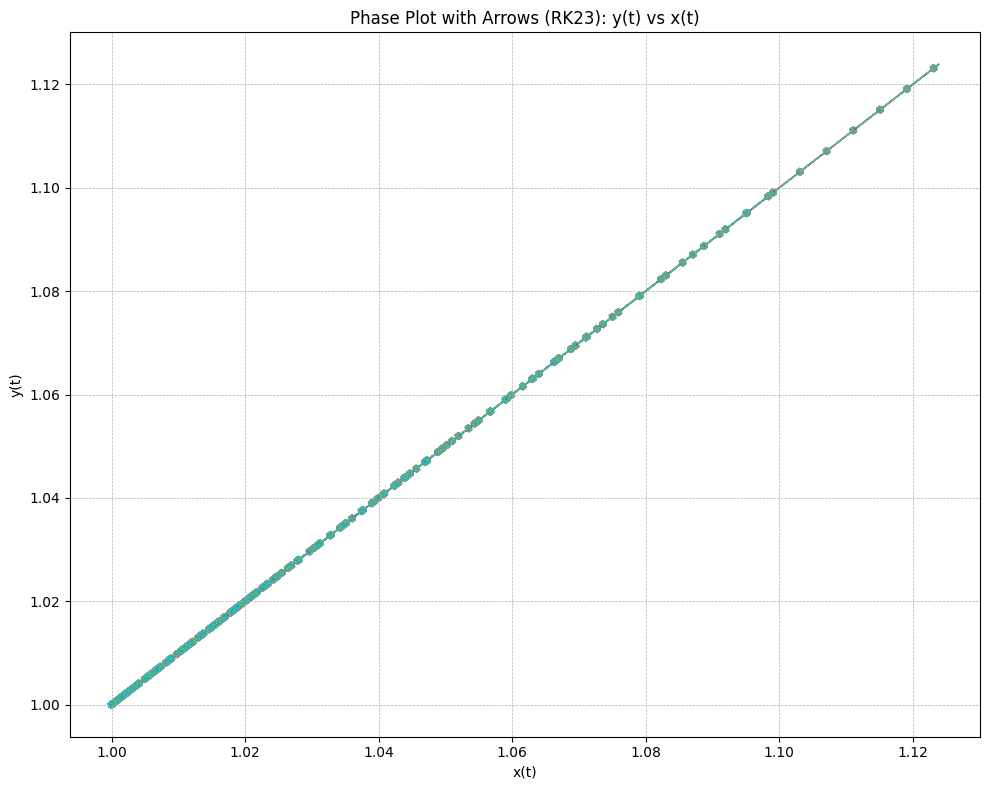

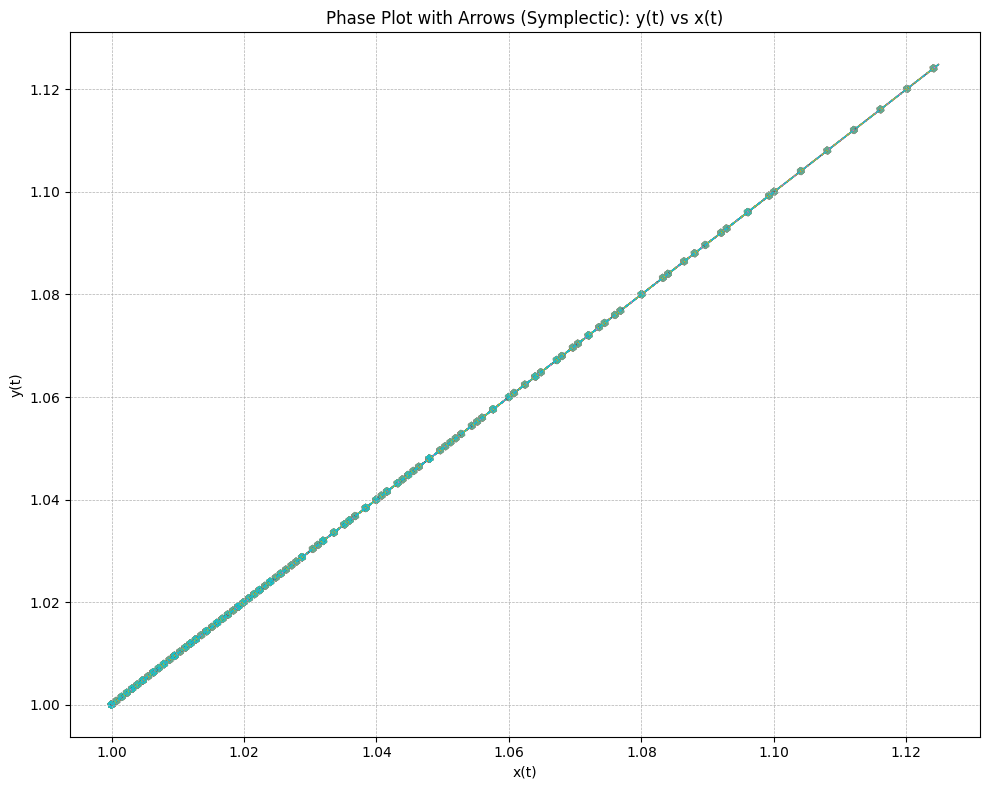

In [26]:
# Cell 4: Plot phase space for each solver with arrows
for method in all_methods:
    plt.figure(figsize=(10, 8))
    for x_vals, y_vals, alpha, K in all_results_2d[method]:
        style = style_map[alpha]
        plt.plot(x_vals, y_vals, linestyle=style["linestyle"], color=style["color"], linewidth=1.0)
        skip = max(3, len(x_vals)//30)
        if len(x_vals[::skip]) >= 3:
            dx = np.gradient(x_vals[::skip])
            dy = np.gradient(y_vals[::skip])
            plt.quiver(x_vals[::skip], y_vals[::skip], dx, dy, angles='xy', scale_units='xy', scale=100, color=style["color"], alpha=0.5, width=0.009)
    plt.xlabel("x(t)")
    plt.ylabel("y(t)")
    plt.title(f"Phase Plot with Arrows ({method}): y(t) vs x(t)")
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [17]:
# Cell 5: Print metrics summary
print("\n=== Method Comparison Table ===")
print("(nfev = number of function evaluations during integration)")
print("{:10s} | {:>10s} | {:>10s}".format("Method", "Time(s)", "nfev"))
print("-" * 35)
for method in all_methods:
    print("{:10s} | {:10.4f} | {:10d}".format(method, timings[method], nfevs[method]))


=== Method Comparison Table ===
(nfev = number of function evaluations during integration)
Method     |    Time(s) |       nfev
-----------------------------------
RK45       |     0.0468 |        580
DOP853     |     0.1225 |       2260
BDF        |     0.1818 |        838
Radau      |     3.1663 |      16125
RK23       |     0.0620 |        550
Symplectic |     0.7627 |      25000


In [18]:
# Cell 6: Lyapunov exponent estimation
print("\n=== Lyapunov Exponent Estimation ===")
delta0 = 1e-9
for alpha in [1e-4]:
    for K in [2.5]:
        rhs = get_rhs_system(alpha, "Lyapunov", error_counts, K)
        sol1 = solve_ivp(rhs, [0, t_end], [x0, y0], t_eval=t_eval, method="RK45")
        sol2 = solve_ivp(rhs, [0, t_end], [x0 + delta0, y0], t_eval=t_eval, method="RK45")
        dists = np.linalg.norm(sol2.y.T - sol1.y.T, axis=1)
        log_d = np.log(dists / delta0)
        lyap_exp = (log_d[-1] - log_d[0]) / (t_eval[-1] - t_eval[0])
        print(f"alpha={alpha:.1e}, K={K:.1f} → λ ≈ {lyap_exp:.4f}")


=== Lyapunov Exponent Estimation ===
alpha=1.0e-04, K=2.5 → λ ≈ 368.4247


In [19]:
# Cell 7: Neimark–Sacker bifurcation detection (approx)
def poincare_map(rhs, x0, y0, t_eval):
    sol = solve_ivp(rhs, [0, t_end], [x0, y0], t_eval=t_eval, method="RK45")
    return sol.y[:, -1]

print("\n=== Neimark–Sacker Bifurcation Check ===")
alpha = 1e-4
K = 2.5
rhs = get_rhs_system(alpha, "NS", error_counts, K)
p0 = poincare_map(rhs, x0, y0, t_eval)
delta = 1e-6
p1 = poincare_map(rhs, x0 + delta, y0, t_eval)
p2 = poincare_map(rhs, x0, y0 + delta, t_eval)

J = np.column_stack([(p1 - p0)/delta, (p2 - p0)/delta])
evals = eigvals(J)
print(f"Eigenvalues of Jacobian: {evals}")
if np.any(np.abs(evals) > 1):
    print("→ Possible Neimark–Sacker bifurcation detected.")
else:
    print("→ No bifurcation detected (eigenvalues within unit circle).")



=== Neimark–Sacker Bifurcation Check ===
Eigenvalues of Jacobian: [8.97197793e+002 4.95842550e+303]
→ Possible Neimark–Sacker bifurcation detected.
